# Scikit-learn Beginner's Template

This notebook contains an example analysis using machine learning methods in scikit-learn.

On the basis of simulated physics data, it guides the reader through a number of steps which will result in a successful analysis by means of a machine learning classifier. Basic concepts such as data visualization, data preprocessing, training/validation/test data split, classifier training and hyperparmeter tuning, as well as classifier performance estimation are covered.

The example at hand mainly addresses people who are new to machine learning, scikit-learn or Python and should provide them with code implementations of basic analysis steps and plots. It does not necessarily claim to yield optimal analysis results - not even good ones, necessarily - but should rather illustrate some fundamental concepts of machine learning application.

---

## Table of Contents

- [Example Analysis](#Example-Analysis)
    - [Preparatory Steps](#Preparatory-Steps)
    - [Data Import](#Data-Import)
    - [Data Visualization](#Data-Visualization)
        - [Histograms of the Variables](#Histograms-of-the-variables)
        - [Scatter matrix](#Scatter-matrix)
        - [Correlation matrix](#Correlation-matrix)
        - [RadViz](#RadViz)
    - [Data Preprocessing](#Data-preprocessing)
    - [Data Split Into Training, Validation and Test Sample](#Data-Split-Into-Training,-Validation-and-Test-Sample)
    - [Model Definition](#Model-Definition)
    - [Model Training](#Model-Training)
    - [Model Evaluation Using Training and Validation Sample](#Model-Evaluation-Using-Training-and-Validation-Sample)
        - [MVA output distribution](#MVA-output-distribution)
        - [Cut efficiencies plot / MVA cut optimization](#Cut-efficiencies-plot-/-MVA-cut-optimization)
        - [ROC curve and Overtraining Check](#ROC-curve-and-Overtraining-Check)
        - [Precision-recall curve](#Precision-recall-curve)
        - [Confusion matrix](#Confusion-matrix)
        - [Classification report](#Classification-report)
    - [Model Application to the Test Sample](#Model-Application-to-the-Test-Sample)
        - [MVA output distribution](#MVA-output-distribution-1291)
        - [ROC curve](#ROC-curve-1292)
        - [Precision-recall curve](#Precision-recall-curve-1293)
        - [Confusion matrix](#Confusion-matrix-1294)
        - [Classification report](#Classification-report-1295)

---

## Example Analysis

This example analysis should provide the reader with basic methods and concepts for successful data analysis using machine learning. The results are quite likely not optimal since only little effort has gone into choice of classifier and hyperparameter finetuning. (Can you improve them?)

### Preparatory Steps

For our analysis, the following imports are required:

In [1]:
import math
import itertools

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import pandas as pd
from pandas.tools.plotting import scatter_matrix, radviz

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

### Data Import

For this example, we use the [Higgs data set](https://archive.ics.uci.edu/ml/datasets/HIGGS) by Daniel Whiteson (Univ. of California Irvine).

The goal of our analysis will be to distinguish between particle collisions (events) which produce a [Higgs boson](https://en.wikipedia.org/wiki/Higgs_boson) (so-called "signal" events) and processes which don't ("background" events). In other words, we have to deal with a binary classification problem.

The data has been produced using Monte Carlo simulations. It is available as a plain CSV file. Each column in this input file represents an attribute (in the context of machine learning usually referred to as a "feature") of the data, while each row corresponds to an individual event. (For demonstration purposes, a [CSV file containing the first 10 events of the Higgs data set](https://raw.githubusercontent.com/tempse/sklearn-beginners-template/master/data/HIGGS_head.csv) has been uploaded to the repository.)

The first column (`class_label`) contains only zeros and ones, representing signal (`class_label` = 1) and background (`class_label` = 0) events. Columns 2-21 contain quantities that are directly measured by the particle detectors in the accelerator. These features are referred to as _low-level features_. Columns 22-28 are specific (and in general often non-linear) combinations of certain low-level features and are derived by physicists. They are called _high-level features_. The rationale behind constructing these features is to provide a machine learning classifier with "more powerful" features in terms of signal-background discrimination ability. It should be noted at this point that there is growing interest in using deep learning methods to obviate the need for physicists to manually develop such features.

In [3]:
attributes = [
    'class_label', # 1 for signal, 0 for background
    ##########################################################
    'lepton1_pT', # vvv  low-level features (columns 1-22)  vvv
    'lepton1_eta',
    'lepton1_phi',
    'missing_energy_mag',
    'missing_energy_phi',
    'jet1_pT',
    'jet1_eta',
    'jet1_phi',
    'jet1_btag',
    'jet2_pT',
    'jet2_eta',
    'jet2_phi',
    'jet2_btag',
    'jet3_pT',
    'jet3_eta',
    'jet3_phi',
    'jet3_btag',
    'jet4_pT',
    'jet4_eta',
    'jet4_phi',
    'jet4_btag', # ^^^  low-level features  ^^^
    ########################################################
    'm_jj', # vvv  high-level features (columns 22--28)  vvv
    'm_jjj',
    'm_lv',
    'm_jlv',
    'm_bb',
    'm_wbb',
    'm_wwbb' # ^^^  high-level features  ^^^
]

# use pandas to import data from the CSV input file
data = pd.read_csv('./data/higgs/HIGGS.csv',
                   header=None,
                   sep=',',
                   names=attributes,
                   usecols=[0,22,23,24,25,26,27,28], # only import specific columns
                   nrows=2000000 # only import a certain number of events (usually determined by memory, training time,...)
                  )

In order to utilize machine learning libraries like scikit-learn, we have to set up our data in form of a feature matrix `X` and a target vector `y`.

`X` contains all events (one event per row) which are characterized by a certain number of attributes/features (organized in columns). Thus, the dimensions of `X` are (number of events)x(number of features).

`y` is a (one-dimensional) vector containing the class labels in form of zeros ("background") and ones ("signal").

This form of data preparation can easily be achieved using the following lines of code.

In [4]:
X = data.drop(['class_label'], axis=1)
y = (data['class_label']).astype(int)

print('Dimensions of feature matrix X: ', X.shape)
print('Dimensions of target vector y:  ', y.shape)

Dimensions of feature matrix X:  (2000000, 7)
Dimensions of target vector y:   (2000000,)


Often, it is important to know whether the dataset is "balanced" (i.e., having about the same number of signal and background events) or "imbalanced" (i.e., containing more events of one class than of the other) when training a classifier and evaluating its performance.

One can learn about the "imbalancedness" of the dataset by looking at the absolute numbers of events in the respective classes.

In [5]:
print('\nTotal number of events in data sample: %d' % X.shape[0])
print('Number of signal events in data sample: %d (%.2f percent)' % (y[y==1].shape[0], y[y==1].shape[0]*100/y.shape[0]))
print('Number of backgr events in data sample: %d (%.2f percent)' % (y[y==0].shape[0], y[y==0].shape[0]*100/y.shape[0]))


Total number of events in data sample: 2000000
Number of signal events in data sample: 1058818 (52.94 percent)
Number of backgr events in data sample: 941182 (47.06 percent)


---

### Data Visualization

In order to get to know the data we are working with, let us create several plots before doing the actual machine learning (ML) later on.

#### Histograms of the variables

As a first step, we want to visualize the distributions of the respective variables of the dataset. We can do this by creating histograms of the variable distributions. It is further useful to divide the distributions into their "signal" and "background" event contributions and plot those on top of each other. In this way, we might be able to develop some intuition about the abilities of the respective variables to distinguish signal events from background (i.e., their "separation power").

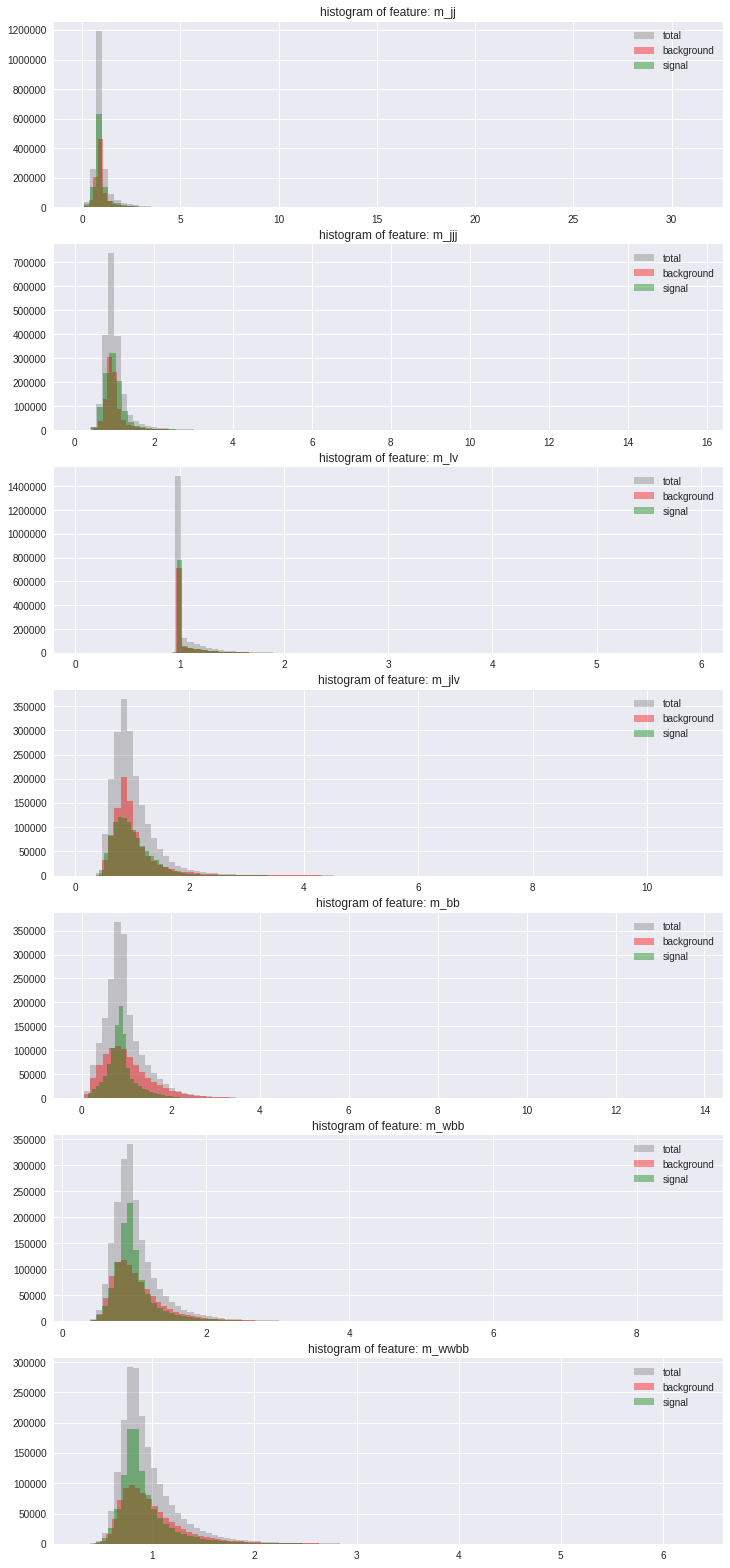

In [6]:
import matplotlib.gridspec as gridspec
plt.figure(figsize=(12, 4*(data.shape[1]-1)))
gs = gridspec.GridSpec(data.shape[1]-1, 1)
for i, cn in enumerate(data.columns[1:data.shape[1]]):
    ax = plt.subplot(gs[i])
    sns.distplot(data[cn], kde=False, label='total', bins=100, color='gray')
    sns.distplot(data[cn][data.class_label == 0], kde=False, label='background', bins=100, color='red')
    sns.distplot(data[cn][data.class_label == 1], kde=False, label='signal', bins=100, color='green')
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
    ax.legend()

plt.show()

Ideally, the respective distributions are different for the two classes, such that signal and background events can be easily distinguished by setting cuts on one or many variables (without necessarily employing machine learning at all). In many cases - like in our dataset - it is difficult to do this because of the huge overlaps of the signal and background distributions. Here, ML techniques are potentially able to show their strengths thanks to their multivariate nature and their ability to exploit correlations between variables.

#### Scatter matrix

We can extract even more information from the data by plotting a so-called "scatter matrix". This matrix visualizes relationships between the input features.

Since we already know that the matrix diagonal elements are represented by straight lines at 45 degrees (due to the 1:1 correlation of the variables with themselves), we replace these elements, e.g., by the "kernel density estimations" of the respective features.

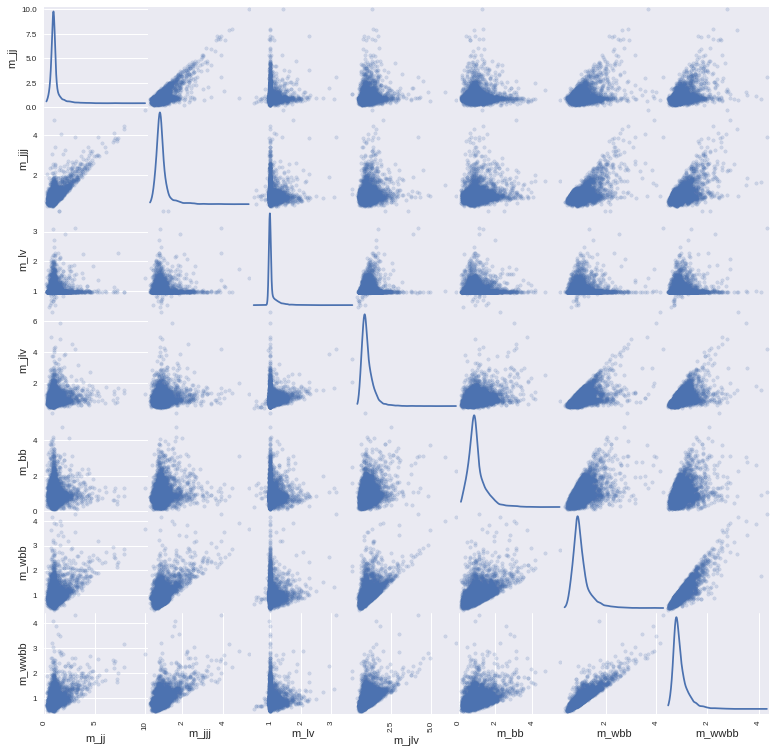

In [7]:
scatter_matrix(data.ix[0:5000,1:28], figsize=(13,13), diagonal='kde', alpha=.2)
plt.show()

#### Correlation Matrix

Another way of displaying relationships between the input features is to compute their "correlation matrix".

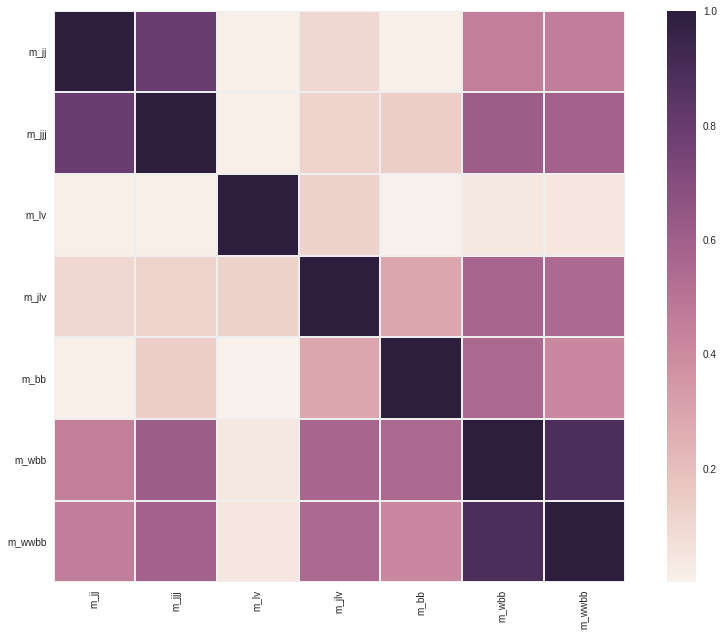

In [8]:
plt.figure()
plt.subplots(figsize=(12,9))
sns.heatmap(X.corr(), square=True, linewidths=1, linecolor='#eeeeee')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout();

#### RadViz

_RadViz is a way of visualizing multi-variate data. It is based on a simple spring tension minimization algorithm. Basically you set up a bunch of points in a plane. In our case they are equally spaced on a unit circle. Each point represents a single attribute. You then pretend that each sample in the data set is attached to each of these points by a spring, the stiffness of which is proportional to the numerical value of that attribute (they are normalized to unit interval). The point in the plane, where our sample settles to (where the forces acting on our sample are at an equilibrium) is where a dot representing our sample will be drawn. Depending on which class that sample belongs it will be colored differently._ (Source: [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/visualization.html#radviz))

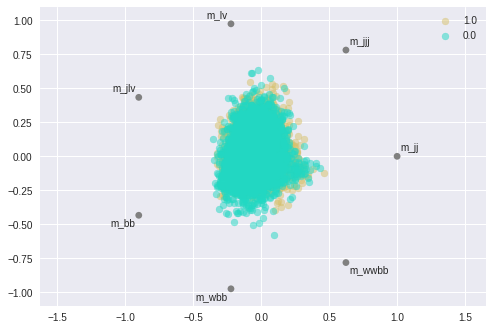

In [9]:
radviz(data.ix[0:10000,:], 'class_label', alpha=.5)

---

### Data Preprocessing

In order to center the data before letting a classifier train on it, we have to subtract the mean and divide by the standard deviation. This has to be separately done for each input feature.

Naturally, scikit-learn provides us with a pre-implemented routine which we can use to do just that.

In [10]:
scaler = StandardScaler()

# first finds the correct values for the mean and the standard deviation ("fit") and
# then transforms the data using these values ("transform")
X = scaler.fit_transform(X)

### Data Split Into Training, Validation and Test Sample

As usual, we split the data into a training, a validation and a test sample.

The classifier is to be trained on the training sample and the validation sample is used for overtraining checks. Once this is done and all the hyperparameters are fixed, the classifier will be applied to the test sample, whereby its actual performance will be evaluated.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=500000,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=500000,
                                                  random_state=43)

print('Number of training samples:   %d' % X_train.shape[0])
print('Number of validation samples: %d' % X_val.shape[0])
print('Number of test samples:       %d' % X_test.shape[0])

Number of training samples:   1000000
Number of validation samples: 500000
Number of test samples:       500000


### Model Definition

By the way of example, we use a "random forest" as a classifier (see the scikit-learn user's guide ([here](http://scikit-learn.org/stable/modules/ensemble.html#forest) or [here](http://scikit-learn.org/stable/modules/tree.html)) and the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for more information on the `RandomForestClassifier`).

Below are the classifier parameters. These parameters always have to be set by the user and strongly influence the performance of the classifier on a given dataset. Unfortunately, these so-called _hyperparameters_ are problem-specific and there are no general rules which indicate the "correct" set of hyperparameters for a given classification task. Therefore, one usually has to (randomly or systematically) try many different settings in order to find an acceptably well performing set of parameters. Often, however, there are some recommendations on how to start off dealing with new data for the first time (see, e.g., [here](http://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use) for general guidelines on how to use random forests).

In [12]:
clf = RandomForestClassifier(n_estimators=500,
                             criterion='gini',
                             max_depth=None,
                             min_samples_split=1000,
                             min_samples_leaf=1,
                             min_weight_fraction_leaf=0.0,
                             max_features='auto',
                             max_leaf_nodes=None,
                             min_impurity_split=1e-07,
                             bootstrap=True,
                             oob_score=False,
                             n_jobs=-1,
                             random_state=None,
                             verbose=0,
                             warm_start=False,
                             class_weight=None)

### Model Training

The actual training of the model is invoked by calling the `fit` method.

In [13]:
clf = clf.fit(X_train, y_train)

As a quick and first classifier evaluation step, we compute the classification accuracy on the training and the validation set. The accuracy is defined as the number of correctly classified events divided by the total number of events.

In [14]:
print("Accuracy on training set:   {:.3f}".format(clf.score(X_train, y_train)))
print("Accuracy on validation set: {:.3f}".format(clf.score(X_val, y_val)))

Accuracy on training set:   0.713
Accuracy on validation set: 0.704


We expect the classifier to achieve a higher accuracy on the training sample than on the validation sample, but we should try to minimize the difference for reasons of classifier generalization ability (see section [ROC curve and Overtraining Check](#ROC-curve-and-Overtraining-Check)).

After training the classifier, we can rank the features in terms of their importance for the given classification task. (The error bars in the following plot correspond to the inter-tree variability of the feature importances.)

Feature ranking:
	1. m_bb 	(0.349881)
	2. m_wbb 	(0.177110)
	3. m_wwbb 	(0.168786)
	4. m_jjj 	(0.126962)
	5. m_jlv 	(0.110234)
	6. m_jj 	(0.053014)
	7. m_lv 	(0.014012)


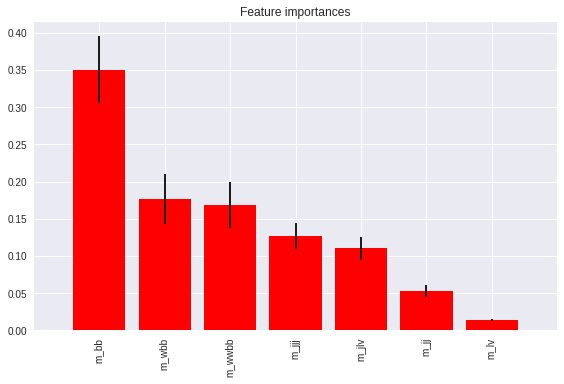

In [15]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
    
print("Feature ranking:")

featureNames = data.columns[data.columns != 'class_label']
    
for f in range(X_train.shape[1]):
    print("\t%d. %s \t(%f)" % (f + 1,
                               featureNames[indices[f]],
                               importances[indices[f]]))
    
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]),
        importances[indices],
        color="r",
        yerr=std[indices],
        align="center")
plt.xticks(range(X_train.shape[1]), featureNames[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()

---

### Model Evaluation Using Training and Validation Sample

After the classifier has been trained, we need to check its performance both on the training as well as on the validation sample in order to monitor overtraining and get a handle on it. In what follows, several methods to evaluate the performance of a trained classifier are shown.

In [16]:
# definition of general plotting parameters
nbins = 100

Now, the classifier is presented with training data (i.e., `X_train`) and new data (i.e., `X_val`) which we want it to make predictions on. This is done by invoking a "predict" function like `predict_proba(X)`. (See the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict) for other predict functions.)

In [17]:
y_train_score = clf.predict_proba(X_train)

y_val_score = clf.predict_proba(X_val)

`y_train_score` and `y_val_score` consist of two columns ('background' and 'signal'), each column containing the predicted probability values for the respective event to be either "background" or "signal".

_NB: In the case of binary classification, the value of a given event in one column uniquely determines the corresponding value in the other column. The reason for this is that all values of a row have to add up to one (i.e., an event is either "background" or "signal" - there is no third option). For the following steps, it is therefore sufficient to process only one of the two columns, since it already contains all the information._

#### MVA output distribution

The following function plots the classifier predictions as a histogram. Additionally, the underlying distributions for the "true signal" and the "true background" are plotted on top of them and returned by the function as arrays.

It is this output distribution which we eventually have to make a cut on in order to classify new data in the future.

In [18]:
def plot_MVAoutput(y_truth, y_score, nbins=100):
    """
    Plots the MVA output as histogram and returns the underlying
    distributions of the positive and the negative class.
    """
    
    # split the array and use only the column containing the
    # probabilities of an event to belong the the "signal" class
    # (can be done in case of 'binary' classification)
    discard, y_score_posClass = np.split(y_score,
                                         2,
                                         axis=1)
    
    y_score_posClass_truePos = y_score_posClass[np.array(y_truth==1)]
    y_score_posClass_trueNeg = y_score_posClass[np.array(y_truth==0)]
    
    plt.figure()

    n_total, bins_total, patches_total = \
        plt.hist(y_score[:,1],
                 bins=nbins,
                 alpha=.25,
                 color='black',
                 label='MVA output')
    
    n_trueNeg, bins_trueNeg, patches_trueNeg = \
        plt.hist(y_score_posClass_trueNeg,
                 bins=nbins,
                 alpha=0.5,
                 color='#dd0000',
                 label='true negative')
    
    n_truePos, bins_truePos, patches_truePos = \
        plt.hist(y_score_posClass_truePos,
                 bins=nbins,
                 alpha=0.5,
                 color='green',
                 label='true positive')
    
    plt.title('MVA output distribution (positive class)')
    plt.xlim(-0.05, 1.05)
    plt.xlabel('MVA output')
    plt.ylabel('Entries')
    plt.legend()
    
    return n_truePos, n_trueNeg

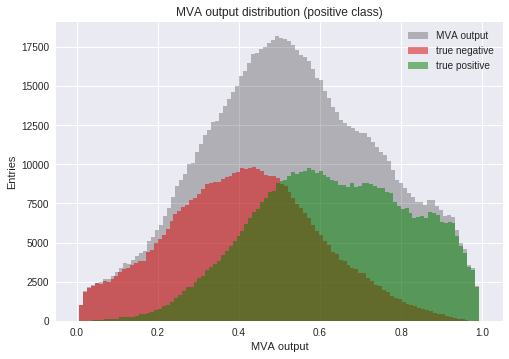

In [19]:
n_truePos, n_trueNeg = plot_MVAoutput(y_train, y_train_score, nbins)

#### Cut efficiencies plot / MVA cut optimization

Now we have to choose an appropriate cut value on the MVA output distribution above. In order to do so, we first perform a scan over the entire MVA output range and calculate signal efficiency, background efficiency and significance for each step in the scan.

Let's consider what happens in a single step of the scan, at a particular MVA output value $x\in[0,1]$: The signal efficiency is defined as the number of signal events $S$ above $x$ (i.e., the number of signal events which pass the momentarily applied MVA cut) divided by the total number of signal events in the data sample. Mathematically: $\text{Eff}_\text{S}=\frac{\text{S}({\text{MVA}\geq x})}{\text{S}({0\leq\text{MVA}\leq 1})}$. Similarly, the background efficiency is given by the number of background events $B$ above $x$ divided by the total number of background events: $\text{Eff}_\text{B}=\frac{\text{B}({\text{MVA}\geq x})}{\text{B}({0\leq\text{MVA}\leq 1})}$. Eventually, the significance at a given MVA output $x$ is calculated to be $\text{Sign}_x = {\text{S}(\text{MVA}\geq x)}\big/{\sqrt{\text{S}(\text{MVA}\geq x)+\text{B}(\text{MVA}\geq x)}}$.

We finally determine the optimal MVA cut as the MVA output value at which the significance distribution has its maximum. In the following plot, this point is marked by a small circle.

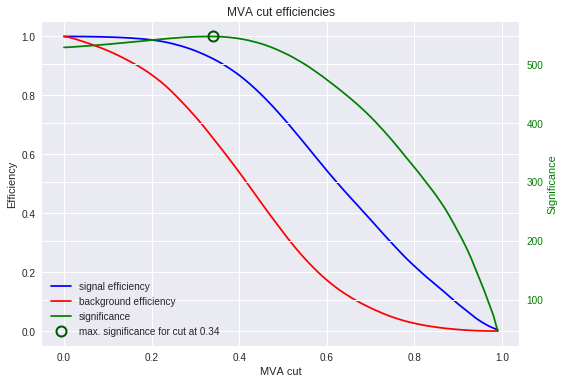

In [20]:
MVAcut = np.empty((0))

plt.figure()
fig, ax1 = plt.subplots()
signal_efficiency = np.empty((0))
backgr_efficiency = np.empty((0))
for i in range(nbins):
    signal_efficiency = np.append(signal_efficiency, \
                                  np.sum(n_truePos[i:n_truePos.shape[0]]) / np.sum(n_truePos))
    backgr_efficiency = np.append(backgr_efficiency, \
                                  np.sum(n_trueNeg[i:n_trueNeg.shape[0]]) / np.sum(n_trueNeg))
    MVAcut = np.append(MVAcut, i/(nbins*1.0))
l1 = ax1.plot(MVAcut, signal_efficiency, label='signal efficiency', color='blue')
l2 = ax1.plot(MVAcut, backgr_efficiency, label='background efficiency', color='red')
ax1.set_xlabel('MVA cut')
ax1.set_ylabel('Efficiency')

ax2 = ax1.twinx()
significance_per_MVAcut = np.empty((0))
for i in range(nbins):
    significance_per_MVAcut = np.append(significance_per_MVAcut, \
                                        np.sum(n_truePos[i:n_truePos.shape[0]]) / \
                                        math.sqrt(np.sum(n_truePos[i:n_truePos.shape[0]] + \
                                                         n_trueNeg[i:n_trueNeg.shape[0]])))
    
l3 = ax2.plot(MVAcut, significance_per_MVAcut,
              label='significance',
              color='green')
pos_max = np.argmax(significance_per_MVAcut)
MVAcut_opt = pos_max/(nbins*1.0)
l4 = ax2.plot(pos_max/(nbins*1.0), significance_per_MVAcut[pos_max],
              label='max. significance for cut at %.2f' % MVAcut_opt,
              marker='o', markersize=10, fillstyle='none', mew=2, linestyle='none',
              color='#005500')
ax2.set_ylabel('Significance', color='green')
ax2.tick_params('y', colors='green')

plt.title('MVA cut efficiencies')
lall = l1+l2+l3+l4
labels = [l.get_label() for l in lall]
ax2.legend(lall, labels, loc='lower left')
plt.tight_layout()

The above-determined MVA cut value is stored in the variable `MVAcut_opt` and used throughout the rest of the code whenever an MVA cut is performed.

#### ROC curve and Overtraining Check

A common way of characterizing the performance of a trained classifier is to plot the so-called [Receiver Operating Characteristic](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html) curve - or short: the ROC curve.

The ROC curve contains the values for true positive rates (number of correctly classified signal events divided by the total number of signal events) and false positive rates (number of incorrectly classified signal events divided by the total number of background events) for all possible MVA cut values. The greater the area under the ROC curve (short: ROC AUC), the better the classifier performance on the particular dataset. A ROC AUC of 0.5 means that the classifier does not perform better than a dummy classifier which _randomly_ assigns events to their classes.

In the ROC plot below, which is drawn from predictions on the training sample, we additionally highlight the working point corresponding to the optimized MVA cut value.

In [21]:
def plot_ROCcurve(y_truth, y_score, workingpoint=-1):
    """
    Plots the ROC curve and (if specified) the chosen working point.
    """
    
    fpr, tpr, thresholds = roc_curve(y_truth, y_score[:,1], pos_label=1)
    roc_auc = roc_auc_score(y_truth, y_score[:,1])
    
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    
    if workingpoint != -1:
        # find and plot threshold closest to the chosen working point
        close_MVAcut_opt = np.argmin(np.abs(thresholds-workingpoint))
    
        plt.plot(fpr[close_MVAcut_opt], tpr[close_MVAcut_opt], 'o', markersize=10,
                 label="threshold at %.2f" % workingpoint, fillstyle="none",
                 mew=2)
    
    plt.legend(loc=4)

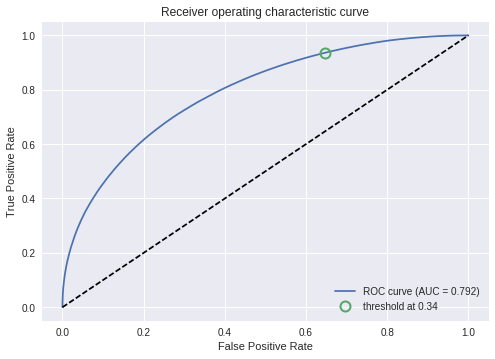

In [22]:
plot_ROCcurve(y_train, y_train_score, MVAcut_opt)

In order to check the classifier for overtraining, let us compare the above ROC curve with the one obtained by classifier predictions on the validation sample:

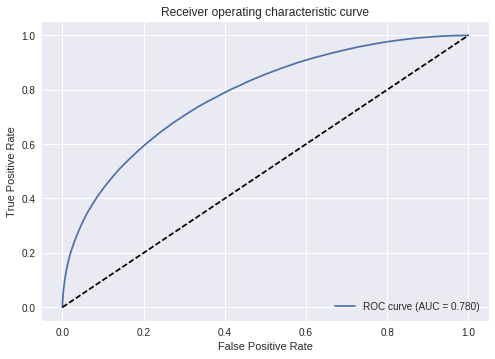

In [23]:
plot_ROCcurve(y_val, y_val_score)

It is expected that the classifier performs better on the training sample than on the validation sample. However, we have to reduce this performance difference if we want the classifier to generalize well to new data (i.e., the held-out test sample, in our case). One way of doing so is to choose a set of hyperparameters that results in similar ROC AUCs of the training and the validation sample.

Below there are several more methods of classifier evaluation. They can be used for overtraining checks as well. But let us agree upon being happy with the ROC AUC comparison as an overtraining check and omit similar comparisons in the following.

If you are looking for a demonstration of overtraining and its negative impact on the classifier performance and generalization ability, you are invited to take a look at [this notebook](https://github.com/tempse/sklearn-beginners-template/blob/master/overtraining%20demo%20-%20random%20forest.ipynb).

#### Precision-recall curve

_In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall)._

_A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly._ (Source and further information: [scikit-learn user's guide](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html))

In [24]:
def plot_precision_recall_curve(y_truth, y_score, workingpoint=-1):
    """
    Plots the precision-recall curve.
    """
    
    precision = dict()
    recall = dict()
    average_precision = dict()
    
    precision, recall, thresholds_PRC = \
        precision_recall_curve(y_truth,
                               y_score[:,1])
    
    average_precision = average_precision_score(y_truth, y_score[:,1])
    
    plt.figure()
    plt.plot(recall, precision, lw=2,
             label='Precision-recall curve of signal class (area = {1:0.2f})'
                    ''.format(1, average_precision))
    
    if workingpoint != -1:
        # find threshold closest to the chosen working point
        close_optimum = np.argmin(np.abs(thresholds_PRC-workingpoint))
        
        plt.plot(recall[close_optimum], precision[close_optimum],
                 'o',
                 markersize=10,
                 label="threshold at %.2f" % workingpoint,
                 fillstyle="none",
                 mew=2)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel(r'Recall $R=T_p / (T_p+F_n)$')
    plt.ylabel(r'Precision $P=T_p / (T_p+F_p)$')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")

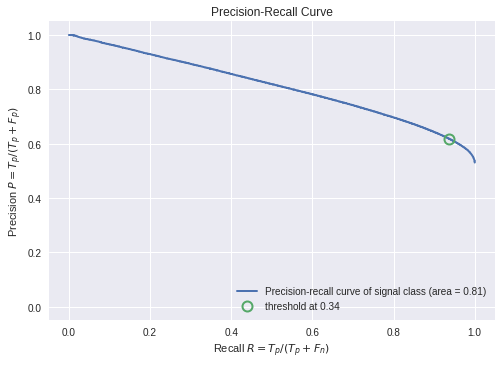

In [25]:
plot_precision_recall_curve(y_train, y_train_score, MVAcut_opt)

#### Confusion matrix

Another way to visualize the amount of correctly and incorrectly classified events is a [_confusion matrix_](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html). The diagonal elements of this matrix represent events which are correctly classified, while the off-diagonal ones contain the mislabeled events. Obviously, we want the diagonal values to be as high as possible.

The below implementation allows the plotted confusion matrix to contain either absolute values or percentages (with each row adding up to one), which is controlled by the `normalize` function parameter.

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Plots the confusion matrix. If 'normalize' is set 'True',
    the output matrix will contain percentages instead of
    absolute numbers.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=45)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [27]:
# Compute confusion matrix
y_train_score_labels = (y_train_score[:,1] > MVAcut_opt)
cnf_matrix = confusion_matrix(y_train, y_train_score_labels)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[166362 304642]
 [ 33852 495144]]


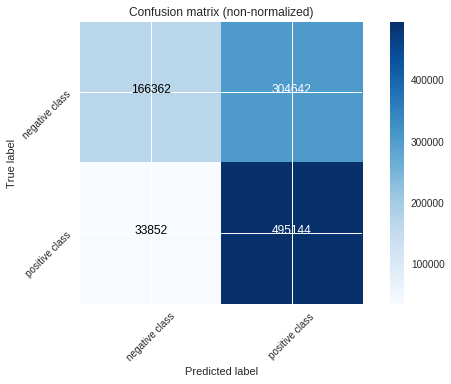

In [28]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=['negative class','positive class'],
                      title='Confusion matrix (non-normalized)')

Normalized confusion matrix
[[ 0.35  0.65]
 [ 0.06  0.94]]


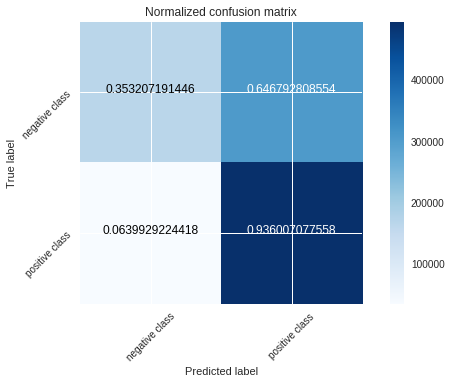

In [29]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=['negative class','positive class'],
                      normalize=True,
                      title='Normalized confusion matrix')

#### Classification report

The classifier output quality can be characterized using different metrics, like _recall_ (i.e., true positive rate), _precision_ or _f1-score_ (see their definitions below).

Denoting $\text{TP}$ as number of true positives (i.e., correctly classified signal events), $\text{FP}$ as number of false positives (i.e., misclassified signal events), $\text{FN}$ as number of false negatives (i.e., misclassified background events) and $\text{TN}$ as true negatives (i.e., correctly classified background events), we define the above-mentioned metrics as follows:

$\text{Recall} = \frac{\text{TP}}{\text{TP}+\text{FN}}$

$\text{Precision} = \frac{\text{TP}}{\text{TP}+\text{FP}}$

$\text{f1-score} = 2\cdot\frac{\text{precision}\cdot\text{recall}}{\text{precision}+\text{recall}}$

The classification report outputs one line per class and reports the above metrics with this class as the positive class. The last column (`support`) contains the number of samples in the respective class according to the ground truth. Finally, the last row (`avg / total`) provides the average of the numbers for each class, weighted by the number of events in the class.

In [30]:
print(classification_report(y_train, y_train_score_labels,
                            target_names=['negative class','positive class']))

                precision    recall  f1-score   support

negative class       0.83      0.35      0.50    471004
positive class       0.62      0.94      0.75    528996

   avg / total       0.72      0.66      0.63   1000000



---

### Model Application to the Test Sample

Up until now, we have tried to find hyperparameters which, ideally, perform equally well on both the training and the validation sample.

With the training and validation phase of our analysis thus being concluded, we want to apply the classifier to the held-out test sample. It is important to note that we are not allowed to change the classifier hyperparameters anymore at this point since this would bias the final classifier evaluation results!

In order to assess the generalization ability of the trained classifier, we proceed analogously to before.

In [31]:
y_test_score = clf.predict_proba(X_test)

#### MVA output distribution

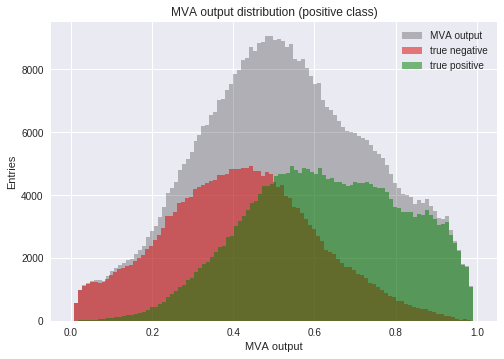

In [32]:
n_truePos, n_trueNeg = plot_MVAoutput(y_test, y_test_score)

#### ROC curve

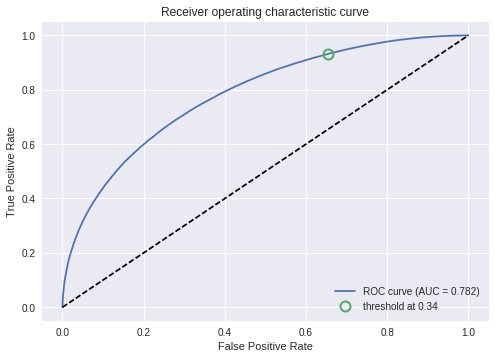

In [33]:
plot_ROCcurve(y_test, y_test_score, MVAcut_opt)

#### Precision-recall curve

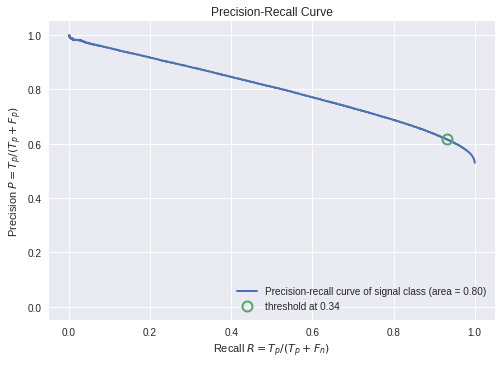

In [34]:
plot_precision_recall_curve(y_test, y_test_score, MVAcut_opt)

#### Confusion matrix

In [35]:
# Compute confusion matrix
y_test_score_labels = (y_test_score[:,1] > MVAcut_opt)
cnf_matrix = confusion_matrix(y_test, y_test_score_labels)
np.set_printoptions(precision=2)

Normalized confusion matrix
[[ 0.35  0.65]
 [ 0.07  0.93]]


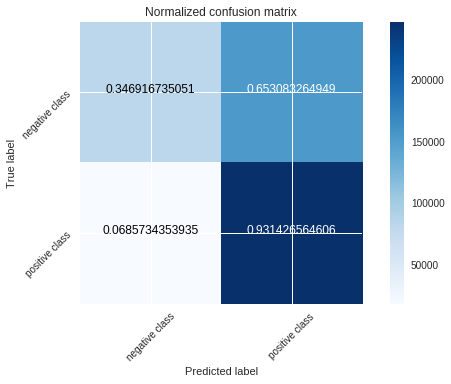

In [36]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=['negative class','positive class'],
                      normalize=True,
                      title='Normalized confusion matrix')

#### Classification report

In [37]:
print(classification_report(y_test, y_test_score_labels,
                            target_names=['negative class','positive class']))

                precision    recall  f1-score   support

negative class       0.82      0.35      0.49    235189
positive class       0.62      0.93      0.74    264811

   avg / total       0.71      0.66      0.62    500000

